In [220]:
import sys, os
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import load_model
import wave
import os
import glob
import librosa
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import (Conv1D, MaxPool1D,MaxPool2D, BatchNormalization, GlobalAvgPool1D, Multiply, GlobalMaxPool1D,
                                     Dense, Dropout, Activation, Reshape, Concatenate, Add)
from keras.layers import Input
from keras.utils import np_utils
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
import pandas as pd
from tensorflow.keras import Model
from keras.layers import InputLayer
from keras.layers import Lambda
from keras import backend as K
from keras.regularizers import l2
import math
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error

### Defining Each Layer

In [228]:
#1. Basic Block 64 features (Input)
def basic_block1(x, num_features=64, weight_decay=0):
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
#2. Basic Block 128 features (Rese)
def basic_block(x, num_features=128, weight_decay=0):
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
#3, Squeeze and Excitation Block
def se_fn(x,num_features=128,amplifying_ratio=16):

    shortcut=x
    num_features=128
    x = GlobalAvgPool1D()(x)
    x = Reshape((1, num_features))(x)
    x = Dense(num_features * amplifying_ratio, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dense(num_features, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    x = Multiply()([x,shortcut])
    return x
#Rese Block 
def rese_block(x, num_features=128, weight_decay=0, amplifying_ratio=16):
    num_features=128
    x = basic_block(x,num_features,weight_decay)
    x = Dropout(0.2)(x)
    x = Conv1D(num_features, kernel_size=3, padding='same', use_bias=True,kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    shortcut=x
    if amplifying_ratio > 0:
        x = se_fn(x, amplifying_ratio)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPool1D(pool_size=3)(x)
    return x
kernel_initializer=tf.keras.initializers.GlorotUniform()
activation=keras.activations.relu
dropout_rate=0.1

### Function To Build Model Based on Training Requirements

In [229]:
def build_model(s):

    layer1=Input(shape=(16000,8))
    layer2=basic_block1(layer1)
    layer3=MaxPool1D(pool_size=3,strides=None)(layer2)
    layer4=rese_block(layer3)
    layer5=rese_block(layer4)
    layer6=rese_block(layer5)
    layer7=rese_block(layer6)
    layer8=rese_block(layer7)
    layer9=GlobalMaxPool1D()(layer8)
    final=Dense(units=256, activation='relu')(layer9)
    # 'c' is used only for classification task
    if (s == 'c'):
        layer10=BatchNormalization()(final)
        layer11=Activation(activation)(layer10)    
        layer12=Dropout(dropout_rate)(layer11)
        out_class=Dense(units=8, activation='softmax')(layer12)
        model=keras.Model(inputs=layer1,outputs=out_class)
    elif (s == 'r'):
    # 'r' is used only for regression task
        layer14=BatchNormalization()(final)
        layer15=Activation(activation)(layer14)    
        layer16=Dropout(dropout_rate)(layer15)
        out_reg=Dense(units=1, activation='linear')(layer16)
        model=keras.Model(inputs=layer1,outputs=out_reg)
    # Combination of classification and regression
    else:
        layer10=BatchNormalization()(final)
        layer11=Activation(activation)(layer10)    
        layer12=Dropout(dropout_rate)(layer11)
        out_class=Dense(units=8, activation='softmax')(layer12)
        # Branching for regression 
        layer14=BatchNormalization()(final)
        layer15=Activation(activation)(layer14)    
        layer16=Dropout(dropout_rate)(layer15)
        out_reg=Dense(units=2, activation='linear')(layer16)
        model=keras.Model(inputs=layer1,outputs=[out_class,out_reg])

    return model

In [5]:
model = build_model('')

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000, 8)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Loading the Training Data

>#### Loading the 38400 audio sample data (W)

In [7]:
with open('/Users/dralbens/Downloads/Reverberant.npy', 'rb') as f:
    g = np.load(f)

>#### Loading the Region Data (R) [Classification Outputs]

In [20]:
r = [6,7,0,5,2,3,4,1]
y = []
regions = np.array([1,0,0,0,0,0,0,0])
for k in r:
    for i in range(200):
        o = np.roll(regions,k)
        y.append(o)
regs = []
for k in range(3):
    for i in y:
        regs.append(list(i))
regs = np.asarray(regs)


> #### Loading the encoded Angle and Distance information (D) [Regression Outputs]

In [238]:
df = pd.read_csv('/Users/dralbens/Desktop/Trained_Noel/angle_Anechoic.csv')
df1 =pd.read_csv('/Users/dralbens/Desktop/Trained_Noel/Distance_Anechoic.csv')

In [242]:
angle = df['angle']
distance = df1['dist']
data = [df["angle"], df1["dist"]]
headers = ["ANGLE", "DISTANCE"]
df3 = pd.concat(data, axis=1, keys=headers)
print(len(df3))
df3

4800


,ANGLE,DISTANCE
0,0.768391,0.408292
1,0.696835,0.406863
2,0.016670,0.010206
3,0.579824,0.278332
4,0.742671,0.497308
...,...,...
4795,0.354086,0.201728
4796,0.933664,0.033747
4797,0.420803,0.336969
4798,0.624904,0.169447


### Splitting and shuffling the loaded datasets into train and test sets

In [128]:
#model.compile(,loss=['mse'], optimizer='adam',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error")])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_c, y_test_c, y_train_r, y_test_r = train_test_split(g,regs,df3, test_size=0.15, shuffle=True)

### Compiling the model

In [132]:
model.compile(loss=[tf.keras.losses.CategoricalCrossentropy(),'mse'], optimizer='adam',metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.RootMeanSquaredError()])

In [133]:
y_train_r = np.asarray(y_train_r)
#All the training data in same datatype
y_train_r

array([[0.26788726, 0.25566391],
       [0.85573728, 0.82931898],
       [0.24980024, 0.0885637 ],
       ...,
       [0.31920349, 0.75693779],
       [0.67711581, 0.11893599],
       [0.59193608, 0.26596699]])

### Training The Model and Saving

In [134]:
model.fit(X_train,[y_train_c,y_train_r],epochs=50,batch_size=8)
model.save('/Users/dralbens/Desktop/Trained_Noel/Complete_with_twist.h5')

Epoch 1/50
510/510 [==============================] - 328s 585ms/step - loss: 0.0880 - dense_11_loss: 0.0348 - dense_12_loss: 0.0531 - dense_11_categorical_accuracy: 0.8558 - dense_11_root_mean_squared_error: 0.1143 - dense_12_categorical_accuracy: 0.8521 - dense_12_root_mean_squared_error: 0.1156
Epoch 2/50
510/510 [==============================] - 264s 518ms/step - loss: 0.0931 - dense_11_loss: 0.0414 - dense_12_loss: 0.0517 - dense_11_categorical_accuracy: 0.8558 - dense_11_root_mean_squared_error: 0.1086 - dense_12_categorical_accuracy: 0.8557 - dense_12_root_mean_squared_error: 0.1087
Epoch 3/50
510/510 [==============================] - 273s 535ms/step - loss: 0.0901 - dense_11_loss: 0.0368 - dense_12_loss: 0.0532 - dense_11_categorical_accuracy: 0.8544 - dense_11_root_mean_squared_error: 0.1098 - dense_12_categorical_accuracy: 0.8543 - dense_12_root_mean_squared_error: 0.1098
Epoch 4/50
510/510 [==============================] - 271s 531ms/step - loss: 0.0890 - dense_11_loss: 0

/Users/dralbens/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Using the Model to predict Test data

In [163]:
ans=model.predict(X_test)

In [155]:
predictions = ans[0]

In [156]:
predictions

array([[1.78337050e-05, 1.10600865e-06, 1.11889054e-09, ...,
        1.46378397e-07, 9.99974489e-01, 4.21566983e-06],
       [1.18810337e-10, 5.44337263e-06, 9.99994397e-01, ...,
        3.84418364e-08, 1.98450180e-11, 1.16446095e-07],
       [1.68314722e-12, 9.99999642e-01, 1.82523845e-08, ...,
        3.11158061e-07, 2.34075819e-15, 3.02036973e-14],
       ...,
       [3.96985549e-17, 1.13715898e-10, 1.98726278e-11, ...,
        1.00000000e+00, 1.32028355e-09, 1.37895812e-13],
       [9.92097446e-11, 1.00000000e+00, 4.32773062e-09, ...,
        8.82849793e-10, 4.64171429e-15, 3.38762167e-13],
       [7.47450539e-12, 6.28426555e-09, 6.98782401e-07, ...,
        1.47493353e-07, 2.12522604e-08, 8.33690379e-08]], dtype=float32)

### Threshold classification from the prediction results

In [157]:
k=0

for i in predictions:
    m = np.argmax(i)
    predictions[k,m]=1
    k=k+1
    
for i in predictions:
    for k in range(len(i)):
        if i[k]!=1:
            i[k]=0
pre=predictions.astype(int)
print(pre)
fact=[]
count=0

for i,k in zip(predictions,y_test_c):
    fact.append(i==k)
    if(i.all()==k.all()):
        count=count+1
predictions=np.asarray(fact)
count=0
for i in predictions:
    if np.all(i)==True:
        count=count+1

[[0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Visualizing the Classification Accuracy

In [212]:
def plotter(x,y):
    post1 = []
    for i in y:
        m = np.where(i==1)
        post1.append(int(m[0])+1)
    post = []
    for i in x:
        m = np.where(i==1)
        post.append(int(m[0])+1)
    f = np.arange(1,len(x)+1)

    plt.scatter(f,post,label="Training",s = 800,color='black')
    plt.scatter(f,post1,label="Predicted",s=400,color='grey')

    plt.legend()
    plt.yticks([0,1,2,3,4,5,6,7,8],fontsize=20)
    plt.xlabel("Audio Samples").set_size(20)
    plt.ylabel("Region Present").set_size(20)
    f1 = np.arange(1,len(x)+1)
    plt.xticks(f1,fontsize=20)

    plt.rcParams["figure.figsize"] = (28.8,10.8)


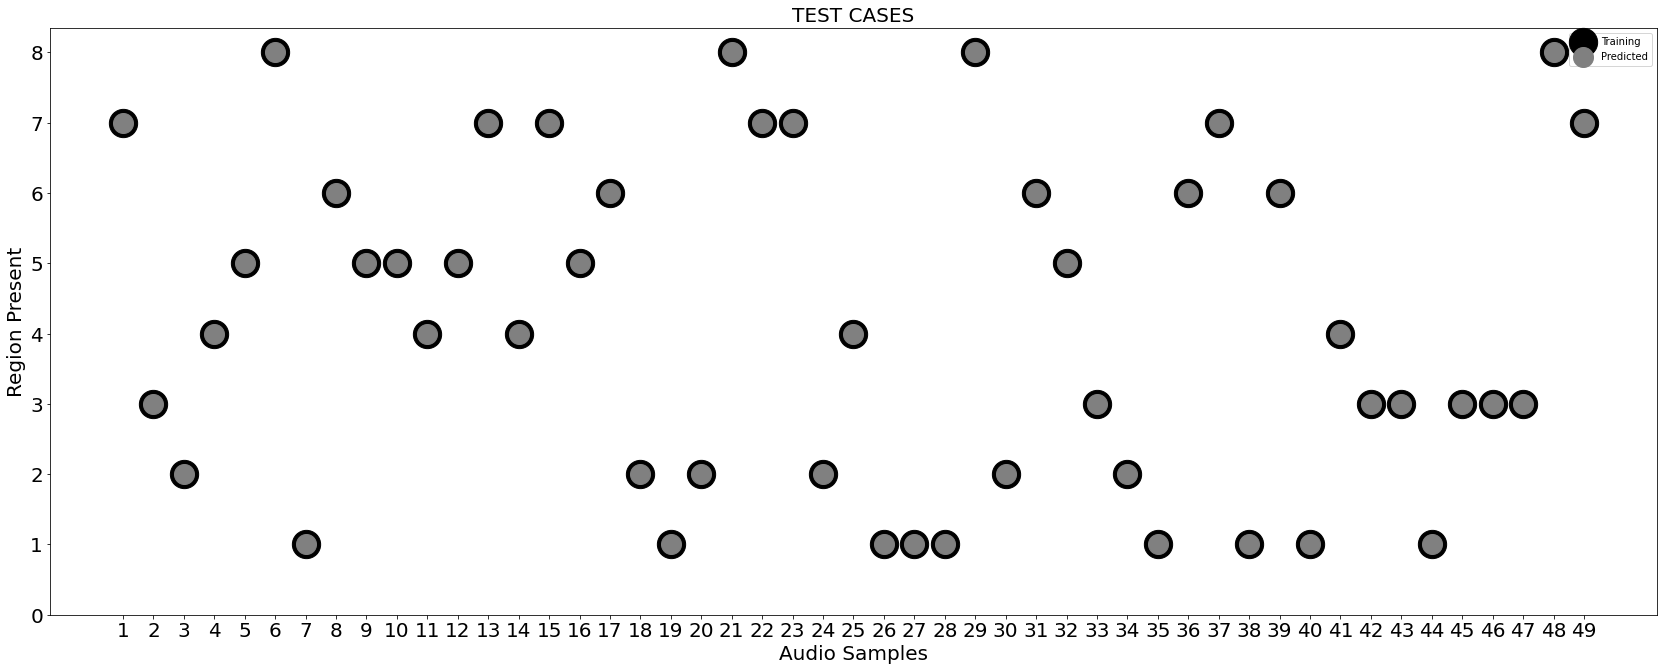

In [256]:
k=0
savers = ['testone','testtwo']
savers1 = ['/Users/dralbens/Desktop/Trained_Noel/setone.png','/Users/dralbens/Desktop/Trained_Noel/settwo.png','/Users/dralbens/Desktop/Trained_Noel/setthree.png','/Users/dralbens/Desktop/Trained_Noel/setfour.png','/Users/dralbens/Desktop/Trained_Noel/setfive.png','/Users/dralbens/Desktop/Trained_Noel/setsix.png','/Users/dralbens/Desktop/Trained_Noel/setseven.png','/Users/dralbens/Desktop/Trained_Noel/set8.png']
i=0
for z in range(1):
    i=i+49
    
    plt.figure()
    plt.title('TEST CASES').set_size(20)
    plotter(pre[k:i],y_test_c[k:i])
    plt.savefig(savers1[z],dpi=100)
    k=i+1



### Picking the Regions that were predicted accurately from testdata

In [192]:
z=[]

for i in range(len(fact)):
    if (np.all(fact[i],axis=0)):
        z.append(i)

In [193]:
result=[]
for i in z:
    res=np.where(pre[i]==1)
    res=res[0]+1
    result.append(res[0])

In [196]:
anglea=[]
anglep=[]
#y_train_r=y_train_r.to_numpy(dtype='float32')

for i in z:
    anglea.append(y_train_r[i][0])
    anglep.append(ans[1][i][0])
anglep=np.array(anglep)

### Decoding the angle regression predictions

In [201]:
angmax=0
angmin=0
actualdeg=[]
preddeg=[]
for i in range(len(result)):
    if(result[i]==1):
        angmax=315
        angmin=270
    elif(result[i]==2):
        angmax=360
        angmin=315
    elif(result[i]==3):
        angmax=45
        angmin=0
    elif(result[i]==4):
        angmax=90
        angmin=45
    elif(result[i]==5):
        angmax=135
        angmin=90
    elif(result[i]==6):
        angmax=180
        angmin=135
    elif(result[i]==7):
        angmax=225
        angmin=180
    else:
        angmax=270
        angmin=225
    actualdeg.append(anglea[i]*45+angmin)
    preddeg.append(anglep[i]*45+angmin)

### Saving the Predictions into csv format for comparison

In [247]:
df = pd.DataFrame(list(zip(actualdeg,preddeg)),columns=['actual','predicted'])
df.to_csv('/Users/dralbens/Desktop/Trained_Noel/Compare_Angle.csv')
df[0:10]

,actual,predicted
0,192.054927,202.376824
1,38.508178,22.466704
2,326.241011,338.056743
3,64.818610,67.291650
4,111.462894,113.441276
5,248.720242,247.026224
6,294.683022,292.628518
7,146.740221,156.180672
8,97.987347,112.989559
9,92.727174,113.724139


### Calculating Mean Absolute Error in Degrees for Angle Regression Outputs

In [227]:
mae = mean_absolute_error(actualdeg,preddeg)
mae

10.27155641322805

### Decoding the Distance regression outputs

In [161]:
dmax = 2.557999
dmin=0.0055702760952

In [180]:
anstest_dist=[]
for i in range(len(y_test_r)):
    temp = ans[1][i][1]*(dmax-dmin)+dmin
    anstest_dist.append(temp)


In [182]:
y_test_r = np.asarray(y_test_r)

In [184]:
ytest_dist=[]
for i in range(len(y_test_r)):
    temp = y_test_r[i][1]*(dmax-dmin)+dmin
    ytest_dist.append(temp)


### Calculating Mean Absolute Error for Distance prediction

In [222]:
mae =mean_absolute_error(anstest_dist,ytest_dist)

In [223]:
mae

0.38424164178578835

### Saving the distance regression outputs in csv format for comparison

In [246]:
df = pd.DataFrame(list(zip(ytest_dist,anstest_dist)), columns = ['Actual','Predicted'])
df.to_csv('/Users/dralbens/Desktop/Trained_Noel/Compare.csv')
df[0:10]

,Actual,Predicted
0,1.641076,0.860226
1,0.390677,0.812933
2,1.101486,0.667248
3,1.981481,1.751100
4,1.623022,1.336593
5,0.693736,1.734495
6,1.401024,1.738194
7,0.127814,0.706831
8,0.632386,1.453747
9,1.338522,1.497801


### Extracting the predicted regression outputs to plot the predicted source Locations

In [252]:
def sc_plot(pred,act,color1,color2):
    
    for i in range(len(pred)):
        p=plt.scatter(pred[i][0],pred[i][1],c=color1)
        a=plt.scatter(act[i][0],act[i][1],c=color2)
    plt.legend((p,a),['predicted','actual'])

### UCA Locations and ROOM edges

In [253]:
M = [4.3066, 1.6934]
M1 = [5.0565,2.4434]
M2 = [1.6934, 4.3066]
M3 = [5.0565999995, 2.4434]
M4=[3.0,3.0]
M5 = [5.5978,1.9022]
M6 = [4.8478,1.1522]
M7=[3.75,3.75]
Mx=np.asarray([3.2121,3.0,2.7878,2.7,2.7878,3.0,3.2121,3.3,3])
My=np.asarray([3.96,4.05,3.96,3.75,3.53,3.45,3.53,3.75,3.75])

### Projecting radial distance and angle on the X and Y axis 

In [254]:
def plotpoint(r,theta):
    center=[3,3.75]
    if(theta<90):
        theta=theta*(math.pi/180)
        y=3.75+(r*math.cos(theta))
        x=3-(r*math.sin(theta))
    elif(theta>90 and theta<180):
        theta =theta-90
        theta=theta*(math.pi/180)
        y=3.75-(r*math.sin(theta))
        x=3-(r*math.cos(theta))
    elif(theta>180 and theta<270):
        theta =theta-180
        theta=theta*(math.pi/180)
        y=3.75-(r*math.cos(theta))
        x=3+(r*math.sin(theta))
    else:
        theta =theta-270
        theta=theta*(math.pi/180)
        y=3.75+(r*math.sin(theta))
        x=3+(r*math.cos(theta))
    return(x,y)

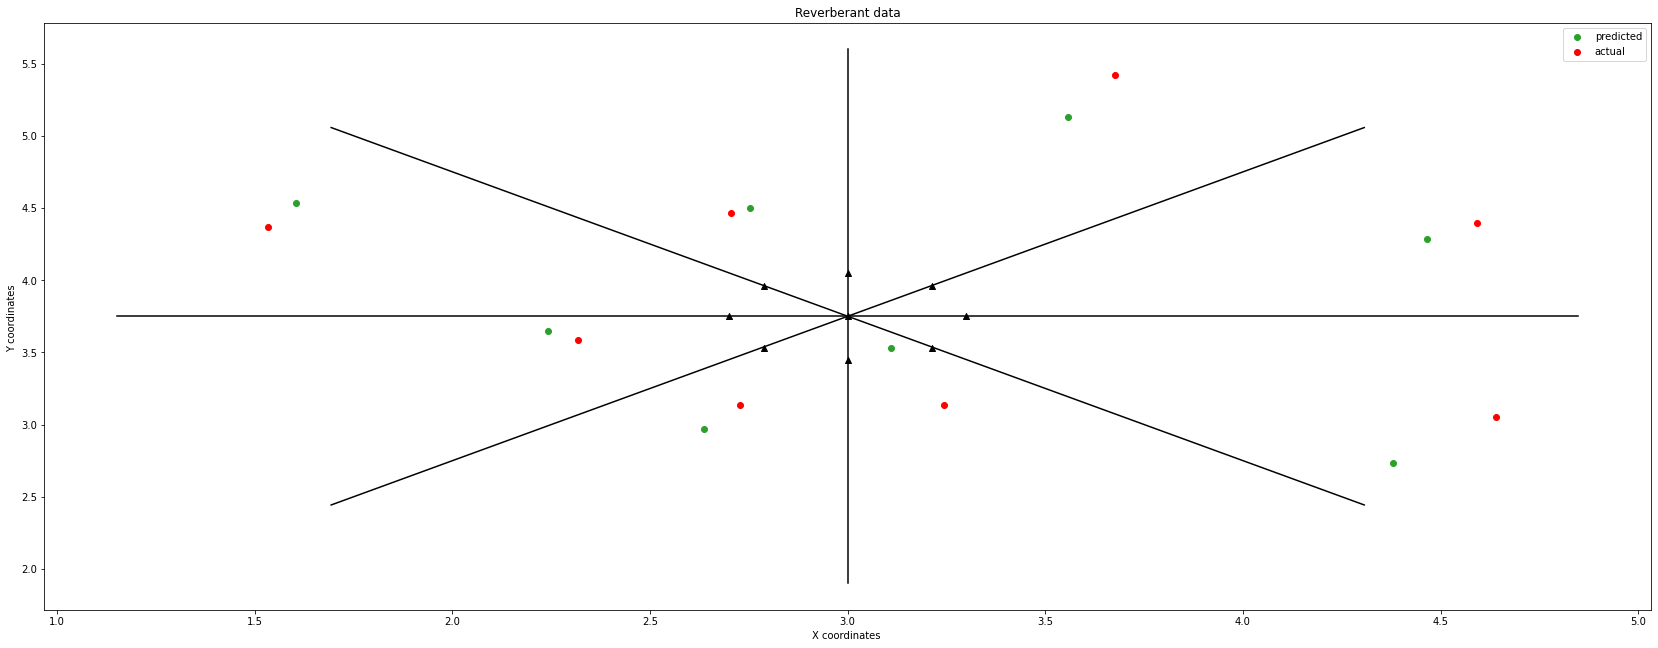

In [255]:
plt.plot(M,M1,'ko',color='white')
plt.plot(M,M1,color='black')
Mlinex = [M[0],M4[0],M2[0],M6[1],M[1],M4[1],M2[1],M6[0],M[0]]
Mliney = [M1[0],M5[0],M3[0],M7[1],M1[1],M5[1],M3[1],M7[0],M1[0]]
# plt.plot(Mlinex,Mliney,'--')
plt.plot(M2,M3,'ko',color='white')
plt.plot(M4,M5,'ko',color='white')
plt.plot(M6,M7,'ko',color='white')
plt.plot(M2,M3,color='black')
plt.plot(M4,M5,color='black')
plt.plot(M6,M7,color='black')
plt.scatter(Mx,My,marker='^',color='#000000')

pred=[]
act=[]
act.append(plotpoint(1.716,292))
pred.append(plotpoint(1.56,290))
act.append(plotpoint(0.67,156))
pred.append(plotpoint(0.86,155))
act.append(plotpoint(0.7757,22.32))
pred.append(plotpoint(0.789,18.24))
act.append(plotpoint(1.784,246.9))
pred.append(plotpoint(1.714,233.60))
act.append(plotpoint(0.6603,201.7))
pred.append(plotpoint(0.2466,206.6))
act.append(plotpoint(0.7021,103.49))
pred.append(plotpoint(0.7660981,97.688))
act.append(plotpoint(1.80,337.9))
pred.append(plotpoint(1.49,338))
act.append(plotpoint(1.59,67.2))
pred.append(plotpoint(1.60,60.68))
sc_plot(pred,act,'#2ca02c','#ff0000')

# pl1=sc_plot(pred,'#2ca02c')
# pl2=sc_plot(act,'#ff0000')
plt.xlabel('X coordinates ')
plt.ylabel('Y coordinates ')
plt.title('Reverberant data')
plt.savefig('Reverberant_predicted_noline.png',dpi=200)
# plt.legend([pred,act])

### Generating the requirements.txt file

In [ ]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))